# Project: MNIST Dataset Image Compression and Reconstruction using Autoencoders:
* The objective of this project is to demonstrate how to compress and reconstruct MNIST images using Autoencoders.

### Author: Mohsen Ghazel (mghazel)
* Date: May 9th, 2021

## Part 1: Python imports and global variables: 

### 1.1) Python imports:

In [44]:
#------------------------------------------------------
# Python imports and environment setup
#------------------------------------------------------
# opencv
import cv2
# numpy
import numpy as np
# matplotlib
import matplotlib.pyplot as plt

# import tansorflow
#----------------------------------
# Importing: Tensorflow 2.0 
# resulted in the following error:
#---------------------------------
# AttributeError: module 'tensorflow' 
# has no attribute 'placeholder'
#---------------------------------
# import tensorflow as tf
#---------------------------------
# We need to revert to using 
# Tensorflow ver 1.x
#---------------------------------
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
#---------------------------------
# import additional functionalities
from __future__ import print_function, division
from builtins import range, input

# import shuffle  from sklearn
from sklearn.utils import shuffle

# import pandas
import pandas as pd

# random number generators values
# seed for reproducing the random number generation
from random import seed
# random integers: I(0,M)
from random import randint
# random standard unform: U(0,1)
from random import random
# time
import datetime
# I/O
import os
# sys
import sys

# display figure within the notebook
%matplotlib inline

#------------------------------------------------------
# Test imports and display package versions
#------------------------------------------------------
# Testing the OpenCV version
print("OpenCV : ",cv2.__version__)
# Testing the numpy version
print("Numpy : ",np.__version__)

OpenCV :  3.4.8
Numpy :  1.19.2


#### 1.2) Global variables:

In [45]:
# set the random_state seed = 100 for reproducibilty
random_state_seed = 100

# the number of visualized images
num_visualized_images = 25

## Part 2: Read the input data:

* We use the MINIST dataset, which was downloaded from the following link: 
  * Kaggle: Digit Recognizer: https://www.kaggle.com/c/digit-recognizer/data
  * The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.
  * Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.
  * The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

  * Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).
  

### 2.1) Load and normalize the training data sets:

In [46]:
# read the training data set
data = pd.read_csv('../large_files/train.csv').values.astype(np.float32)
# normalize the training data to [0,1]:
x_train = data[:, 1:] / 255.0
# format the class type to integer
y_train = data[:, 0].astype(np.int32)
# shuffle the data
x_train, y_train = shuffle(x_train, y_train)

#------------------------------------------------------
# Display a summary of the training data:
#------------------------------------------------------
# the number of training images
num_train_images = x_train.shape[0]
print("----------------------------------------------")
print("Training data:")
print("----------------------------------------------")
print("x_train.shape: ", x_train.shape)
print("y_train.shape: ", y_train.shape)
print("Number of training images: ", num_train_images)
print("Image size: ", x_train.shape[1:])
print("----------------------------------------------")
print("Classes/labels:")
print("----------------------------------------------")
print('The target labels: ' + str(np.unique(y_train)))
print("----------------------------------------------")

----------------------------------------------
Training data:
----------------------------------------------
x_train.shape:  (42000, 784)
y_train.shape:  (42000,)
Number of training images:  42000
Image size:  (784,)
----------------------------------------------
Classes/labels:
----------------------------------------------
The target labels: [0 1 2 3 4 5 6 7 8 9]
----------------------------------------------


### 2.2) Visualize some of the training images and their associated targets:
#### 2.2.1) First implement a visualization functionality to visualize the number of randomly selected images:

In [47]:
"""
# A utility function to visualize multiple images:
"""
def visualize_images_and_labels(num_visualized_images = 25, dataset_flag = 1):
  """To visualize images.

      Keyword arguments:
         - num_visualized_images -- the number of visualized images (deafult 25)
         - dataset_flag -- 1: training dataset, 2: test dataset
      Return:
         - None
  """
  #--------------------------------------------
  # the suplot grid shape:
  #--------------------------------------------
  num_rows = 5
  # the number of columns
  num_cols = num_visualized_images // num_rows
  # setup the subplots axes
  fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 10))
  # set a seed random number generator for reproducible results
  seed(random_state_seed)
  # iterate over the sub-plots
  for row in range(num_rows):
      for col in range(num_cols):
        # get the next figure axis
        ax = axes[row, col];
        # turn-off subplot axis
        ax.set_axis_off()
        #--------------------------------------------
        # if the dataset_flag = 1: Training data set
        #--------------------------------------------
        if ( dataset_flag == 1 ): 
          # generate a random image counter
          counter = randint(0,num_train_images)
          # get the training image
          image = np.squeeze(x_train[counter,:])
          # get the target associated with the image
          label = y_train[counter]
        #--------------------------------------------
        # dataset_flag = 2: Test data set
        #--------------------------------------------
        else: 
          # generate a random image counter
          counter = randint(0,num_test_images)
          # get the test image
          image = np.squeeze(x_test[counter,:])
          # get the target associated with the image
          label = y_test[counter]
        #--------------------------------------------
        # display the image
        #--------------------------------------------
        ax.imshow(image.reshape(28,28), cmap=plt.cm.gray_r, interpolation='nearest')
        # set the title showing the image label
        ax.set_title('y =' + str(label), size = 8)

#### 2.2.2) Call the function to visualize the randomly selected training images:

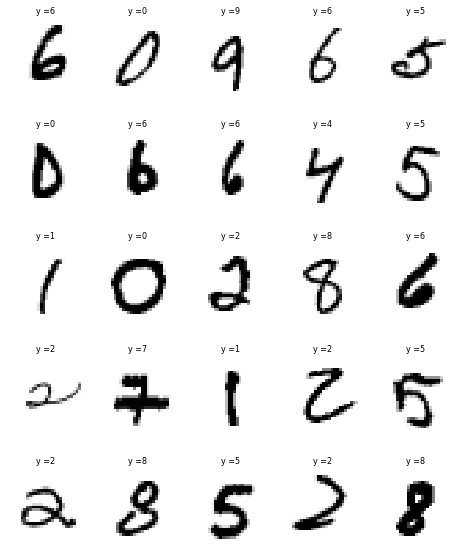

In [48]:
# the number of selected training images
num_visualized_images = 25
# call the function to visualize the training images
visualize_images_and_labels(num_visualized_images, 1)

### 2.3) Examine the number of images for each class of the training and testing subsets:

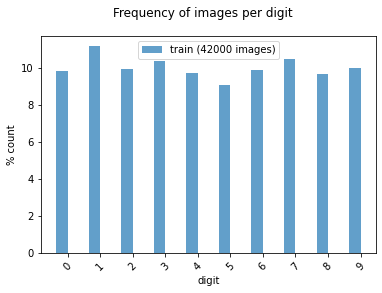

In [49]:
# create a histogram of the number of images in each class/digit:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('digit')
    plt.ylabel(ylabel_text)
 
plt.suptitle('Frequency of images per digit')
plot_bar(y_train, loc='left')
plt.legend([
    'train ({0} images)'.format(len(y_train))
]);

## Part 3: Implement the Autoencoder:
### 3.1) Implement the Autoencoder class:

In [58]:
class Autoencoder:
  def __init__(self, D, M):
    """
    Autoencoder constructor
    """
    # represents a batch of training data
    self.X = tf.placeholder(tf.float32, shape=(None, D))

    # input -> hidden
    self.W = tf.Variable(tf.random_normal(shape=(D, M)) * np.sqrt(2.0 / M))
    self.b = tf.Variable(np.zeros(M).astype(np.float32))

    # hidden -> output
    self.V = tf.Variable(tf.random_normal(shape=(M, D)) * np.sqrt(2.0 / D))
    self.c = tf.Variable(np.zeros(D).astype(np.float32))

    # construct the reconstruction
    self.Z = tf.nn.relu(tf.matmul(self.X, self.W) + self.b)
    logits = tf.matmul(self.Z, self.V) + self.c
    self.X_hat = tf.nn.sigmoid(logits)

    # compute the cost
    self.cost = tf.reduce_sum(
      tf.nn.sigmoid_cross_entropy_with_logits(
        labels=self.X,
        logits=logits
      )
    )

    # create the trainer
    self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(self.cost)

    # set up session and variables for later
    self.init_op = tf.global_variables_initializer()
    self.sess = tf.InteractiveSession()
    self.sess.run(self.init_op)

  def fit(self, X, epochs=30, batch_sz=64):
    """
    Fit the model
    """
    costs = []
    n_batches = len(X) // batch_sz
    print("-----------------------------")
    print("n_batches:", n_batches)
    for i in range(epochs):
      print("-----------------------------")
      print("epoch:", i)
      print("-----------------------------")
      np.random.shuffle(X)
      for j in range(n_batches):
        batch = X[j*batch_sz:(j+1)*batch_sz]
        _, c, = self.sess.run((self.train_op, self.cost), feed_dict={self.X: batch})
        c /= batch_sz 
        costs.append(c)
        # display the cost for selected epochs
        if j % 200 == 0:
          print("iter: %d, cost: %.3f" % (j, c))
    print("-----------------------------")
    print('Training completed successfully!')
    print("-----------------------------")
    #----------------------------------------
    # display the cost/function as a function 
    # of the epochs
    #----------------------------------------
    # create a figure and set its axis
    fig_size = (8,5)
    # create the figure 
    plt.figure(figsize=fig_size)
    plt.plot(costs)
    plt.title("Training lossas function of the epoch number", fontsize = 12)
    plt.xlabel("Epoch number", fontsize = 12)
    plt.ylabel("Loss", fontsize = 12)
    plt.show()
        
  def predict(self, X):
    """
    Generate Autoencoder reconstruction of the input X
    """
    return self.sess.run(self.X_hat, feed_dict={self.X: X})

### 3.2) Instantiate and fit the Autoencoder:

-----------------------------
n_batches: 656
-----------------------------
epoch: 0
-----------------------------
iter: 0, cost: 561.439
iter: 200, cost: 89.177
iter: 400, cost: 72.817
iter: 600, cost: 65.689
-----------------------------
epoch: 1
-----------------------------
iter: 0, cost: 67.116
iter: 200, cost: 64.267
iter: 400, cost: 61.165
iter: 600, cost: 60.009
-----------------------------
epoch: 2
-----------------------------
iter: 0, cost: 57.817
iter: 200, cost: 57.601
iter: 400, cost: 53.689
iter: 600, cost: 57.553
-----------------------------
epoch: 3
-----------------------------
iter: 0, cost: 55.786
iter: 200, cost: 55.598
iter: 400, cost: 51.415
iter: 600, cost: 57.002
-----------------------------
epoch: 4
-----------------------------
iter: 0, cost: 54.759
iter: 200, cost: 58.953
iter: 400, cost: 56.898
iter: 600, cost: 53.679
-----------------------------
epoch: 5
-----------------------------
iter: 0, cost: 53.436
iter: 200, cost: 52.933
iter: 400, cost: 53.145


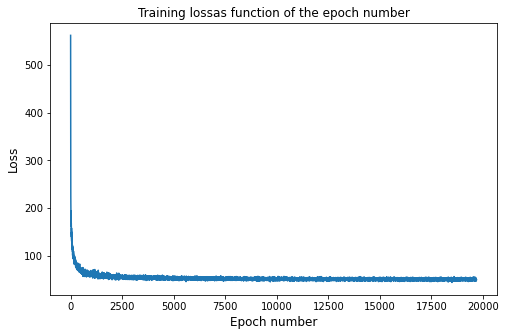

In [59]:
# Instantiate the Autoencoder
model = Autoencoder(784, 300)
# Fit the Autoencoder to the training data and plot the loss/cost function
model.fit(x_train)

### 3.3) Use the trained Autoencoder to reconstruct the input images:
* Randomly select input images and reconstruct them using the trained Autoencoder:

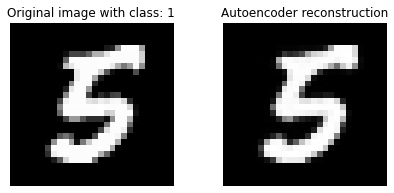

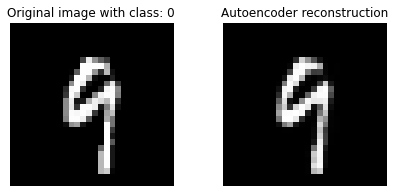

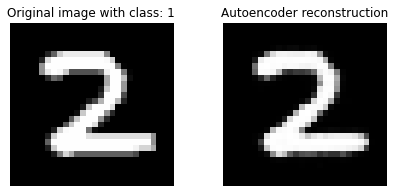

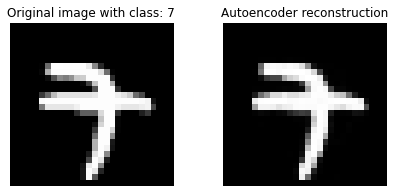

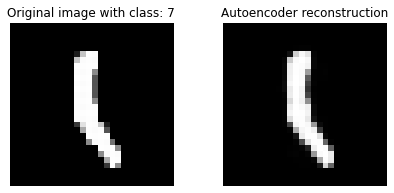

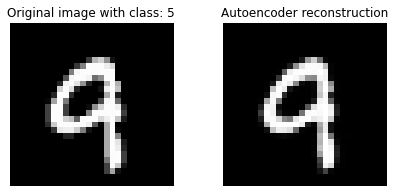

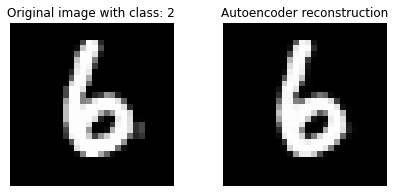

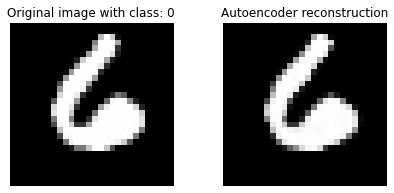

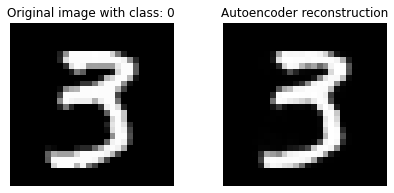

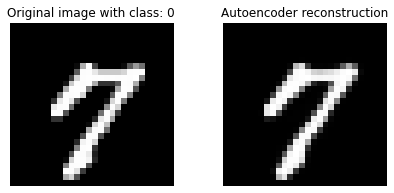

In [55]:
# the number of reconstructed images
num_reconstructed_images = 10
for i in range(num_reconstructed_images):
    #----------------------------------------
    # Step 1: select a random input image:
    #----------------------------------------
    i = np.random.choice(len(x_train))
    x = x_train[i]
    k = y_train[i]
    im = model.predict([x]).reshape(28, 28)
    #----------------------------------------
    # display the original and reconstructed 
    # images:
    #----------------------------------------
    # create a figure and set its axis
    fig_size = (7,3)
    # create the figure 
    plt.figure(figsize=fig_size)
    # display the sample
    plt.subplot(1,2,1)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.title("Original image with class: " + str(k), fontsize = 12)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(im, cmap='gray')
    plt.title("Autoencoder reconstruction", fontsize = 12)
    plt.axis('off')
    plt.show()


#### Step 5: Display a successful execution message:

In [56]:
# display a final message
# current time
now = datetime.datetime.now()
# display a message
print('Program executed successfully on: '+ str(now.strftime("%Y-%m-%d %H:%M:%S") + "...Goodbye!\n"))

Program executed successfully on: 2021-05-10 15:06:07...Goodbye!

